In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,GRU
from keras.optimizers import SGD# 随机梯度下降法

Using TensorFlow backend.


#### 第2步：加载历史数据文件

In [4]:
dataset = pd.read_csv(r'D:\资料\IBM历史数据19801124-20000905.csv', index_col='date', parse_dates=(['date']))


In [5]:
def date001(x):
    date002 = re.match(r'(\d{4}).?(\d*).?(\d*)',x)
    nian = date002.group(1)
    yue = date002.group(2)
    ri =date002.group(3)
    date003 = nian + '-' + yue + '-' +ri
    return date003
da = pd.DataFrame(dataset.index)
dataset.index = da['date'].apply(lambda x: date001(x))
print(dataset.head())

               收盘      开盘       高       低    交易量     涨跌幅
date                                                    
2000-9-5   131.19  132.81  133.31  130.81  4.11M  -1.82%
2000-9-1   133.62  133.06  134.94  132.62  5.78M   1.21%
2000-8-31  132.02  131.88  134.19  131.62  5.47M   1.31%
2000-8-30  130.31  130.75  131.50  129.56  4.93M  -1.93%
2000-8-29  132.88  131.50  134.25  131.00  6.04M   1.05%


In [6]:
dataset.shape

(5000, 6)

In [7]:
#检查数据是否有缺失值
train_set = dataset[:'1986-10-10':-1].iloc[:,0:1]
test_set = dataset['1986-10-10':'1988-10-10':-1].iloc[:,0:1]

In [8]:
train_set.shape

(1487, 1)

In [9]:
test_set.shape

(506, 1)

#### 定义显示函数

In [10]:
def plot_predictions(test_result, predict_result):
    """
    :param test_result: 真实值测试结果
    :param predict_result: 预测值结果
    :return:
    """
    fig = plt.figure(figsize=[15, 7], dpi=200)
    ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])
    ax.set_xlabel('time', fontsize='10')
    ax.set_ylabel('stock price', fontsize='10')
    ax.plot(test_result, color='r', label='IBM True Stock Price')
    ax.plot(predict_result, color='b', label='IBM Predicted Stock Price')
    plt.legend()
    plt.show()

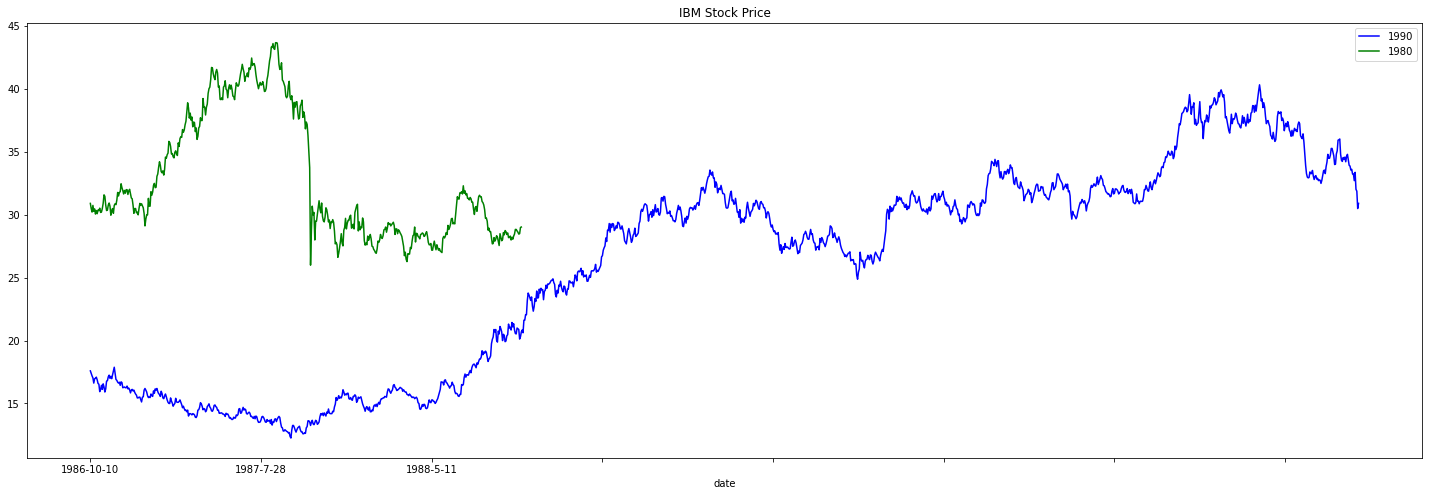

In [11]:
dataset['开盘'][:'1986-10-10':-1].plot(figsize=[25,8], legend=True,color='b')
dataset['开盘']['1986-10-10':'1988-10-10':-1].plot(figsize=[25,8], legend=True,color='g')
plt.title('IBM Stock Price')
plt.legend(["1990","1980"])
plt.show()

In [12]:
# 归一化：将每一维的特征映射到指定区间：【0，1】
sc = MinMaxScaler(feature_range=[0,1])# 最大最小值归一化
train_set_scaled = sc.fit_transform(train_set)
print(train_set_scaled.shape)
train_set_scaled

(1487, 1)


array([[0.19010324],
       [0.18262727],
       [0.1758633 ],
       ...,
       [0.6988252 ],
       [0.6496974 ],
       [0.66429334]])

In [13]:
# 创建序列数据集（训练和测试）
# 60个时间步为一个样本，1输出
x_train = []
y_train = []
for i in range(60, 1487):
    x_train.append(train_set_scaled[i-60:i,0])
    y_train.append(train_set_scaled[i,0])
         
x_train, y_train = np.array(x_train), np.array(y_train)

In [14]:
x_train.shape

(1427, 60)

In [15]:
print(y_train)
x_train[0:2]

[0.10217159 0.11569954 0.11676753 ... 0.6988252  0.6496974  0.66429334]


array([[0.19010324, 0.18262727, 0.1758633 , 0.17016732, 0.15557138,
        0.16803133, 0.16909932, 0.17230331, 0.16482734, 0.15450338,
        0.15236739, 0.13136347, 0.13777145, 0.1491634 , 0.13777145,
        0.15343539, 0.14453542, 0.13029548, 0.13919544, 0.16126735,
        0.16233535, 0.17337131, 0.17799929, 0.16909932, 0.1747953 ,
        0.16803133, 0.17906728, 0.18903524, 0.2004272 , 0.18262727,
        0.16589534, 0.16340335, 0.15806337, 0.15557138, 0.15806337,
        0.1491634 , 0.15913136, 0.15699537, 0.14239943, 0.14346743,
        0.14453542, 0.14239943, 0.14239943, 0.14702741, 0.13919544,
        0.14133143, 0.13670345, 0.12780349, 0.13563546, 0.13777145,
        0.13349947, 0.13563546, 0.12922748, 0.1245995 , 0.12139551,
        0.11356355, 0.11356355, 0.11569954, 0.11569954, 0.10893556],
       [0.18262727, 0.1758633 , 0.17016732, 0.15557138, 0.16803133,
        0.16909932, 0.17230331, 0.16482734, 0.15450338, 0.15236739,
        0.13136347, 0.13777145, 0.1491634 , 0.1

In [16]:
# LSTM输入:(samples, sequence_length, features)
# 将训练集重构，转换成LSTM网络可以识别的数据reshape:训练集(2700,60) --->(2700 , 60 , 1)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [17]:
x_train

array([[[0.19010324],
        [0.18262727],
        [0.1758633 ],
        ...,
        [0.11569954],
        [0.11569954],
        [0.10893556]],

       [[0.18262727],
        [0.1758633 ],
        [0.17016732],
        ...,
        [0.11569954],
        [0.10893556],
        [0.10217159]],

       [[0.1758633 ],
        [0.17016732],
        [0.15557138],
        ...,
        [0.10893556],
        [0.10217159],
        [0.11569954]],

       ...,

       [[0.77216091],
        [0.74866501],
        [0.73869705],
        ...,
        [0.72872909],
        [0.75222499],
        [0.70416518]],

       [[0.74866501],
        [0.73869705],
        [0.73656105],
        ...,
        [0.75222499],
        [0.70416518],
        [0.6988252 ]],

       [[0.73869705],
        [0.73656105],
        [0.73762905],
        ...,
        [0.70416518],
        [0.6988252 ],
        [0.6496974 ]]])

#### 搭建模型

In [18]:
model = Sequential()
#LSTM 第一层
model.add(LSTM(128,return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

# 第二层
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))

#第三层
model.add(LSTM(128))
model.add(Dropout(0.2))

# Dense层
model.add(Dense(units=1))
y_train

array([0.10217159, 0.11569954, 0.11676753, ..., 0.6988252 , 0.6496974 ,
       0.66429334])

In [19]:
# 模型编译
model.compile(optimizer='adadelta',loss='mse')

# 训练模型
model.fit(x_train, y_train, epochs=40, batch_size=72)

Epoch 1/40
1427/1427 [==============================] - 3s 2ms/step - loss: 0.0431
Epoch 2/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0122
Epoch 3/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0094
Epoch 4/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0113
Epoch 5/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0050
Epoch 6/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0066
Epoch 7/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0113
Epoch 8/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 9/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0050
Epoch 10/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0071
Epoch 11/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0071
Epoch 12/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0044
E

#### 构建数据集进行预测

In [2]:
dataset_total = pd.concat((dataset['开盘'][:'1986-10-10':-1],dataset['开盘']['1986-10-10':'1988-10-10':-1]),axis=0)
# 获取输入数据
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values

NameError: name 'pd' is not defined

In [1]:
dataset_total

NameError: name 'dataset_total' is not defined

In [21]:
inputs

array([32.94, 32.97, 33.41, 33.28, 33.28, 33.53, 33.09, 32.81, 33.06,
       33.12, 32.84, 32.91, 32.72, 32.78, 32.75, 32.5 , 32.75, 33.12,
       33.5 , 33.56, 33.28, 33.84, 34.19, 34.81, 34.5 , 34.5 , 34.75,
       35.28, 35.28, 35.  , 34.69, 34.  , 34.03, 34.84, 35.09, 35.94,
       35.97, 36.03, 34.81, 34.34, 34.25, 34.56, 34.41, 34.59, 34.22,
       34.66, 34.81, 34.38, 33.94, 33.88, 33.56, 33.62, 33.25, 33.25,
       32.72, 33.38, 32.03, 31.88, 30.5 , 30.91, 30.91, 30.5 , 30.22,
       30.75, 30.28, 30.47, 30.06, 30.34, 30.09, 30.38, 30.34, 30.53,
       30.19, 30.22, 30.5 , 30.91, 31.59, 31.47, 30.78, 30.34, 30.38,
       30.78, 30.94, 30.69, 29.97, 30.34, 30.5 , 30.12, 30.75, 30.88,
       30.81, 31.16, 31.78, 31.5 , 31.78, 31.84, 32.47, 32.16, 31.94,
       31.66, 31.94, 31.72, 32.  , 32.  , 31.62, 31.91, 32.03, 31.69,
       31.34, 31.28, 30.78, 30.12, 30.5 , 30.5 , 30.16, 30.22, 30.  ,
       30.5 , 30.91, 30.75, 30.88, 30.72, 30.56, 30.09, 29.12, 29.66,
       30.  , 30.  ,

In [22]:
# 归一化
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [23]:
inputs.shape

(566, 1)

In [24]:
# 准备测试集进行预测
x_test = []
for i in range(60 , 566):
    x_test.append(inputs[i-60:i,0])
    
x_test=np.array(x_test)
x_test.shape

(506, 60)

In [25]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [26]:
x_test.shape

(506, 60, 1)

In [27]:
predict_test = model.predict(x_test) # 预测

In [28]:
predict_test.shape 

(506, 1)

In [29]:
predict_stock_price = sc.inverse_transform(predict_test)

In [30]:
predict_stock_price

array([[32.082832],
       [31.811554],
       [31.53091 ],
       [31.246374],
       [30.98073 ],
       [30.735626],
       [30.518843],
       [30.324312],
       [30.157194],
       [30.013058],
       [29.896591],
       [29.806845],
       [29.745502],
       [29.70168 ],
       [29.669636],
       [29.652441],
       [29.658978],
       [29.704714],
       [29.784956],
       [29.8731  ],
       [29.94407 ],
       [29.989809],
       [30.019943],
       [30.044334],
       [30.061525],
       [30.054657],
       [30.030083],
       [29.998056],
       [29.955912],
       [29.920443],
       [29.901365],
       [29.898542],
       [29.917362],
       [29.9704  ],
       [30.04862 ],
       [30.148388],
       [30.263166],
       [30.399542],
       [30.545454],
       [30.68527 ],
       [30.803446],
       [30.901094],
       [30.974691],
       [31.031845],
       [31.0772  ],
       [31.104607],
       [31.120909],
       [31.133312],
       [31.137098],
       [31.123484],


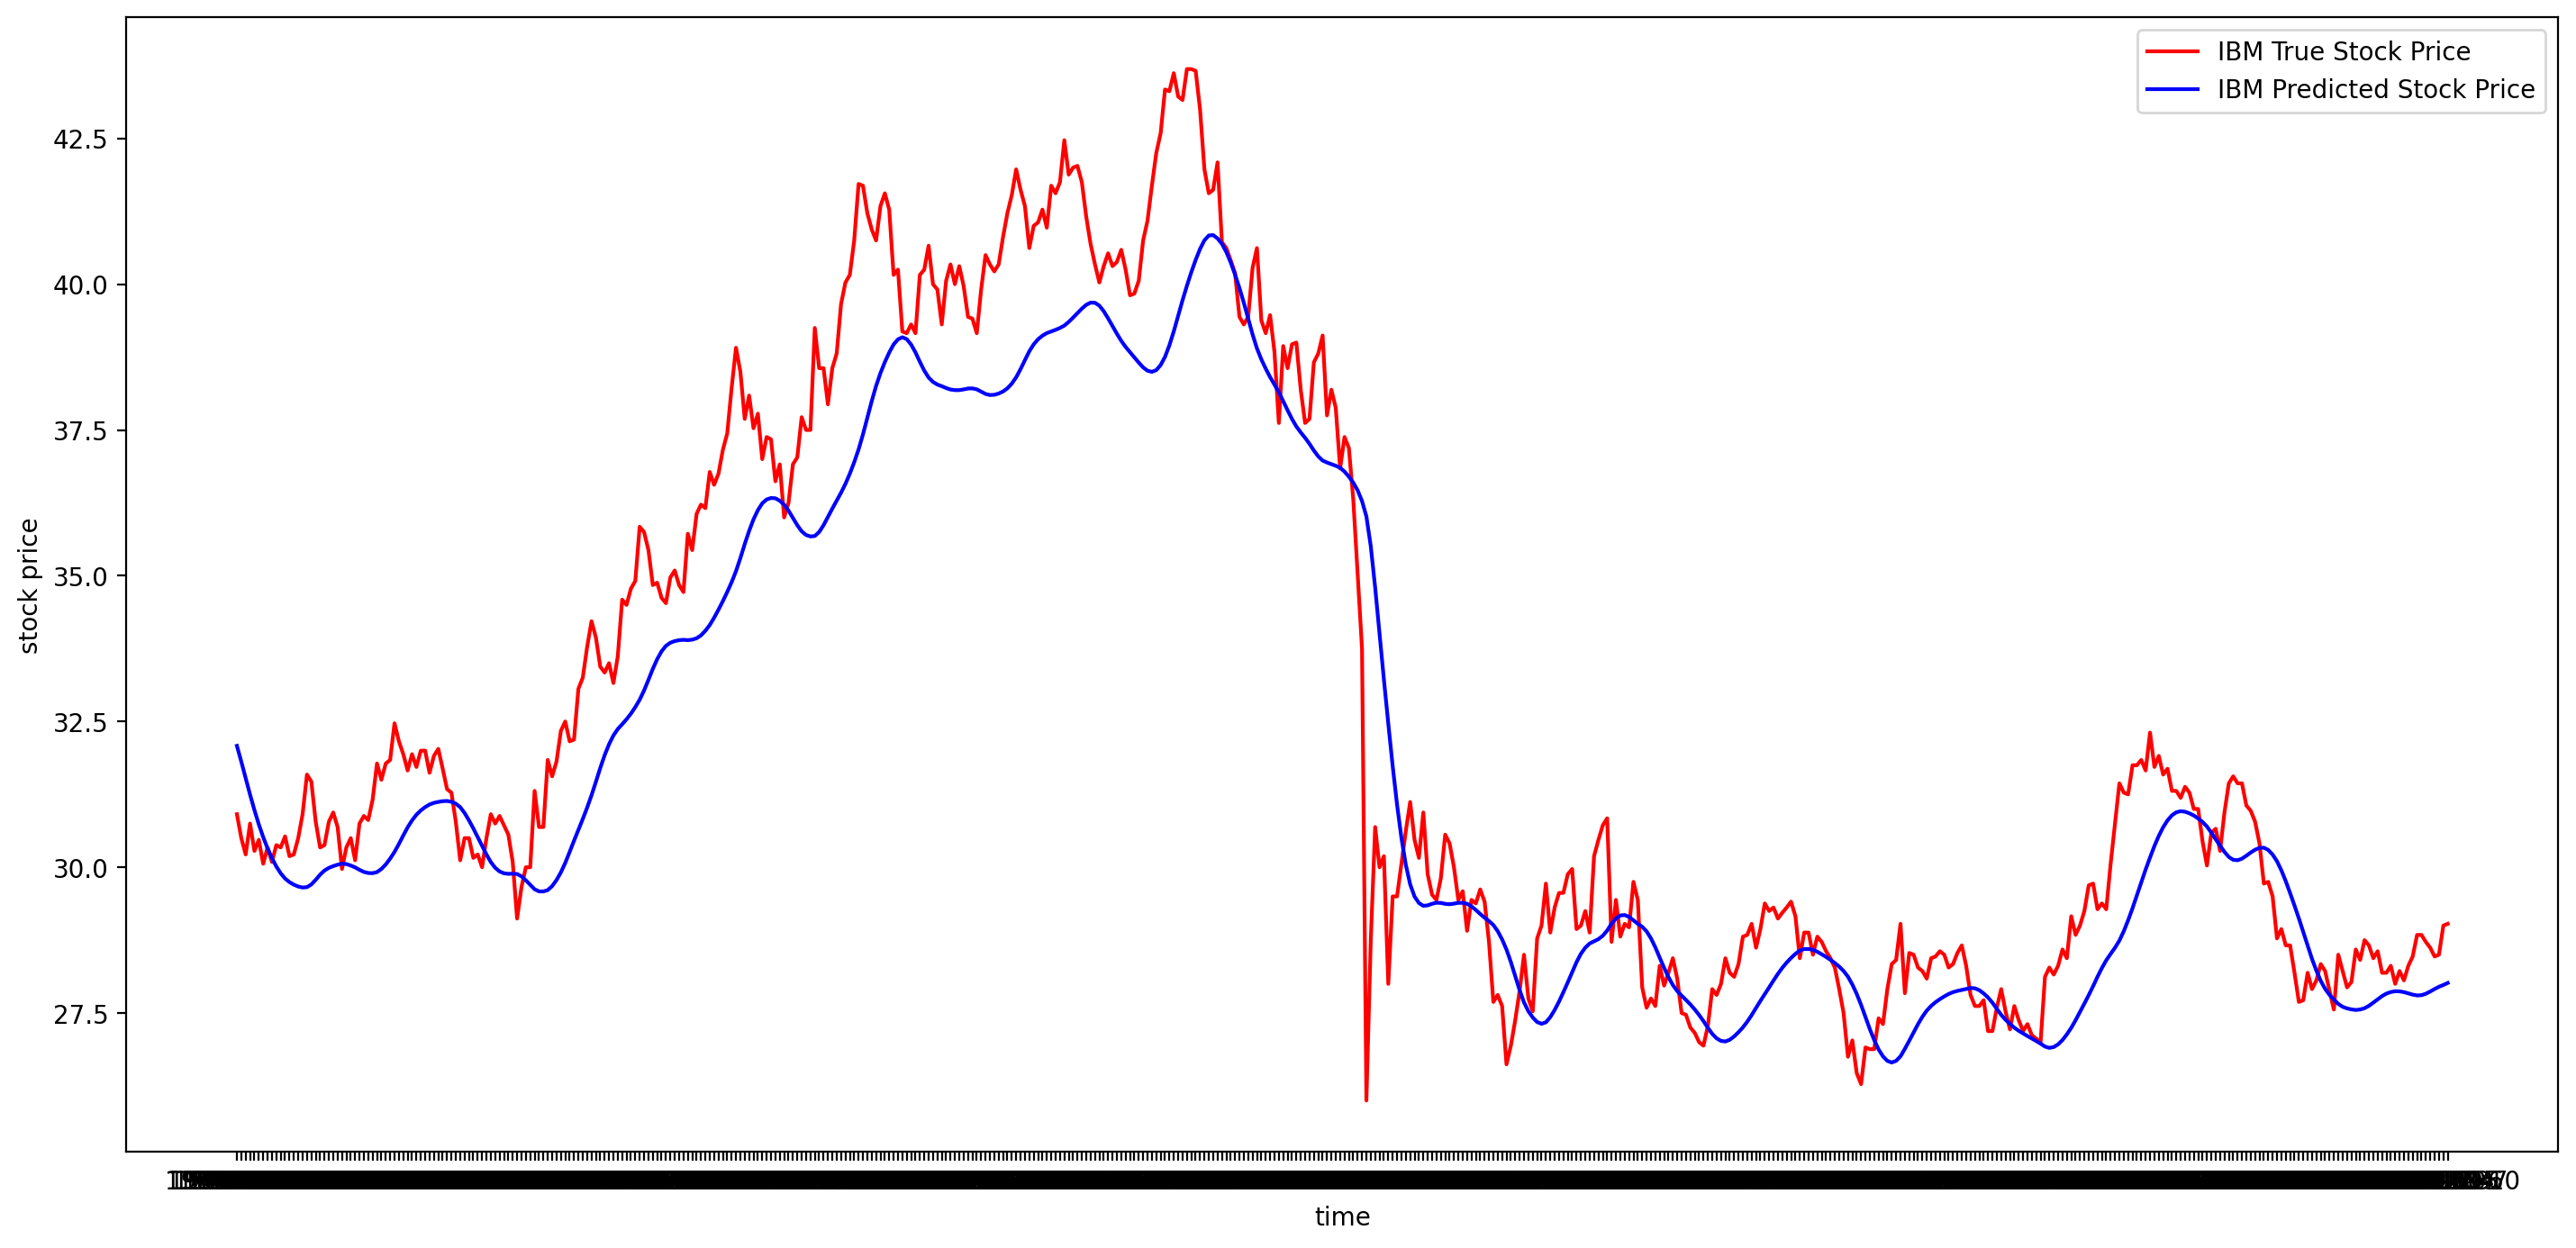

In [31]:
plot_predictions(test_set, predict_stock_price) 

#### 基于GRU 预测

In [32]:
model_gru = Sequential()
model_gru .add(GRU(50, return_sequences = True,input_shape = (x_train.shape[1], 1), activation='tanh'))

In [33]:
model_gru.add(Dropout(0.2))
model_gru.add(GRU(50, activation='tanh'))

In [34]:
model_gru.add(Dropout(0.2))

In [35]:
model_gru.add(Dense(1))

In [36]:
# 编译
model_gru.compile(optimizer=SGD(lr=0.01,decay=1e-7,momentum=0.9),loss='mse')

In [37]:
#训练
history = model_gru.fit(x_train, y_train, epochs = 40, batch_size = 72)

Epoch 1/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.1160
Epoch 2/40
1427/1427 [==============================] - 1s 1ms/step - loss: 0.0173
Epoch 3/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0050
Epoch 4/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0040
Epoch 5/40
1427/1427 [==============================] - 1s 1ms/step - loss: 0.0037
Epoch 6/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0033
Epoch 7/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0033
Epoch 8/40
1427/1427 [==============================] - 1s 1ms/step - loss: 0.0031
Epoch 9/40
1427/1427 [==============================] - 2s 1ms/step - loss: 0.0027
Epoch 10/40
1427/1427 [==============================] - 1s 1ms/step - loss: 0.0029
Epoch 11/40
1427/1427 [==============================] - 1s 1ms/step - loss: 0.0026
Epoch 12/40
1427/1427 [==============================] - 1s 1ms/step - loss: 0.0023
E

In [38]:
# 准备测试集进行预测
x_test = []
for i in range(60 , 566):
    x_test.append(inputs[i-60:i,0])
    
x_test=np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [39]:
GRU_predicted = model_gru.predict(x_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted)

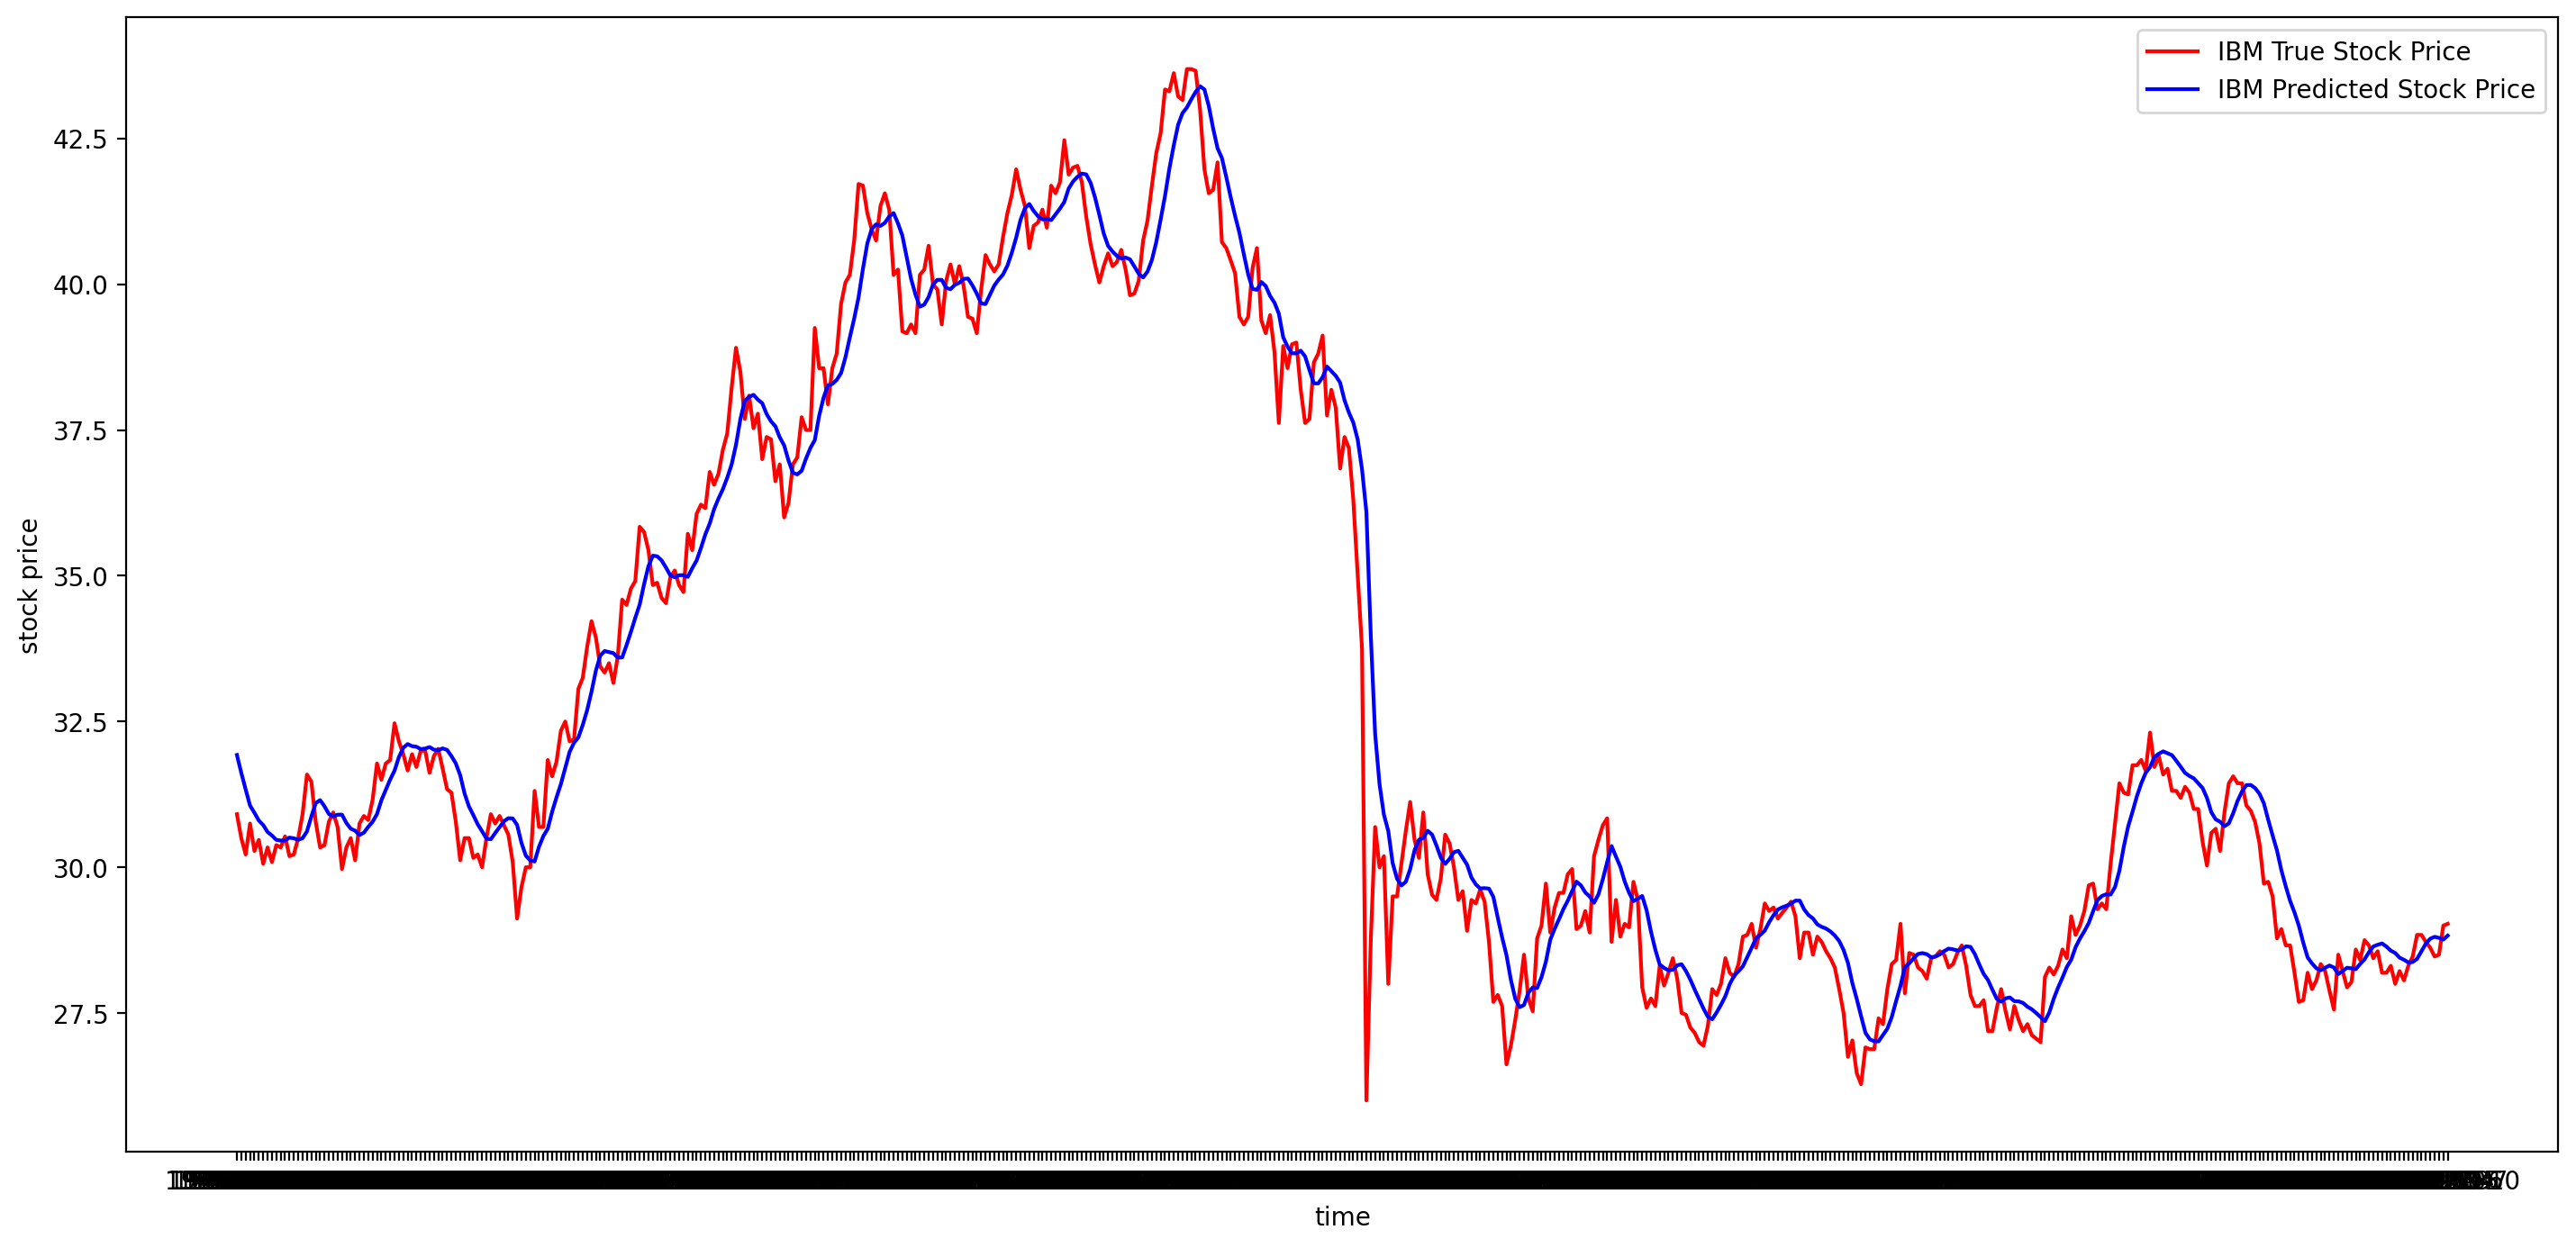

In [40]:
#可视化
plot_predictions(test_set,GRU_predicted_stock_price)

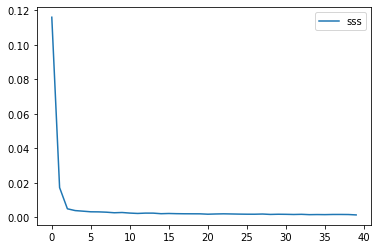

In [41]:
plt.plot(history.history['loss'],label='sss')
plt.legend()
plt.show()